# Recurrent Neural Networks (RNNs)

This notebook contains examples of using RNNs for classification and regression.

In [1]:
from datasets import list_datasets, load_dataset

In [2]:
import nlp
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, Input, Model

# Keras imports
from tensorflow.keras.layers import Embedding
from tensorflow.keras.initializers import Constant
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, SimpleRNN, GRU
from tensorflow.keras.callbacks import ModelCheckpoint

# metrics
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

# word2vec
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

In [3]:
# versions of libraries - noticed problems with Text vecotrization in lower versions
tf.__version__

'2.8.0'

## Loading Dataset

Here I am using a poem sentiment dataset under the category of sentiment-classification on huggingface. 

In [4]:
# load dataset (X-tweets; Y-emotion)

#####
# DATA - https://huggingface.co/datasets/poem_sentiment
#####
dataset = load_dataset("poem_sentiment")

#dataset = load_dataset("emotion")

# load different datasets
train = dataset['train']
test = dataset['test']
val = dataset['validation']

Using custom data configuration default
Reusing dataset poem_sentiment (/Users/dreyceyalbin/.cache/huggingface/datasets/poem_sentiment/default/1.0.0/4e44428256d42cdde0be6b3db1baa587195e91847adabf976e4f9454f6a82099)


  0%|          | 0/3 [00:00<?, ?it/s]

In [50]:
###
# Data preperation
###
index2meaning = {0 : "negative",
                 1 : "positive",
                 2 : "no_impact",
                 3 : "mixed"}
## training data
train_samples = [x['verse_text'] for x in train]
train_labels = np.array([x['label'] for x in train]) # already numerical
## validation data
val_samples = [x['verse_text'] for x in val]
val_labels = np.array([x['label'] for x in val]) # already numerical
## test data
test_samples = [x['verse_text'] for x in test]
test_labels = np.array([x['label'] for x in test]) # already numerical

# obtain class balance data
print(f"count of 0 label in data set is {sum(train_labels == 0)}")
print(f"count of 1 label in data set is {sum(train_labels == 1)}")
print(f"count of 2 label in data set is {sum(train_labels == 2)}")
print(f"count of 3 label in data set is {sum(train_labels == 3)}")


# # clean dataset
# train_samples_cleaned = []
# train_labels_cleaned = []
# count_dict = {0 : 0, 1:0, 2:0, 3:0}
# for index, value in enumerate(train_labels):
#     value = int(value)
#     if count_dict[value] <= 155:
#         train_samples_cleaned.append(train_samples[index])
#         train_labels_cleaned.append(train_labels[index])
#     count_dict[value] += 1
    
# # clean original values
# train_samples = np.array(train_samples_cleaned.copy())
# train_labels = np.array(train_labels_cleaned.copy())

# # obtain class balance data
# print(f"count of 0 label in data set is {sum(train_labels == 0)}")
# print(f"count of 1 label in data set is {sum(train_labels == 1)}")
# print(f"count of 2 label in data set is {sum(train_labels == 2)}")
# print(f"count of 3 label in data set is {sum(train_labels == 3)}")

# print(train_samples_cleaned)
# print(train_labels_cleaned)

count of 0 label in data set is 155
count of 1 label in data set is 133
count of 2 label in data set is 555
count of 3 label in data set is 49


In [51]:
len(train_labels)

892

In [28]:
# Create vectorizer to tokenize sentences.

# parameters
EMBEDDED_VEC_LENGTH = 100
MAX_VOCABULARY = 10000
# vectorize
vectorizer = TextVectorization(max_tokens=MAX_VOCABULARY, 
                               output_sequence_length=EMBEDDED_VEC_LENGTH, 
                               output_mode='int')
text_ds = tf.data.Dataset.from_tensor_slices(train_samples).batch(128) ## Read batches of 128 samples
vectorizer.adapt(text_ds)

In [29]:
## Print out top five words in the vocab
print(len(vectorizer.get_vocabulary())) ## We set max_tokens=10000
vectorizer.get_vocabulary()[:5]
## Text an example of what a string looks like after vectorization
output = vectorizer([["I feel good today again"]])

1505


In [30]:
## Create a map to get the unique list of the vocabulary
#####
# COPIED FROM LECTURE
####
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [31]:
## Vectorize our data (Convert the string data to integer data)

# Feature vectors
x_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
x_val = vectorizer(np.array([[s] for s in val_samples])).numpy()
x_test = vectorizer(np.array([[s] for s in test_samples])).numpy()

print(x_train)
# Labels (not categorical!)
CATEGORICAL = False
if CATEGORICAL:
    y_train = to_categorical(train_labels)
    y_val = to_categorical(val_labels)
    y_test = to_categorical(test_labels)
else: 
    y_train = np.array(train_labels)
    y_val = np.array(val_labels)
    y_test = np.array(test_labels)

[[   9  863 1409 ...    0    0    0]
 [  14 1173   28 ...    0    0    0]
 [   3   10   19 ...    0    0    0]
 ...
 [   2  298  342 ...    0    0    0]
 [ 209  490  989 ...    0    0    0]
 [   6    2  148 ...    0    0    0]]


In [32]:
# Make sure data has correct shape
# reshape into [samples, timesteps, features]

# x_train_no_emb = np.reshape(x_train, (len(x_train), EMBEDDED_VEC_LENGTH, 1)) / float(len(voc))
# x_val_no_emb = np.reshape(x_val, (len(x_val), EMBEDDED_VEC_LENGTH, 1)) / float(len(voc))
# x_test_no_emb = np.reshape(x_test, (len(x_test), EMBEDDED_VEC_LENGTH, 1)) / float(len(voc))


x_train_no_emb = np.reshape(x_train, (len(x_train), EMBEDDED_VEC_LENGTH, 1))
x_val_no_emb = np.reshape(x_val, (len(x_val), EMBEDDED_VEC_LENGTH, 1)) 
x_test_no_emb = np.reshape(x_test, (len(x_test), EMBEDDED_VEC_LENGTH, 1))

In [33]:
x_train_no_emb

array([[[   9],
        [ 863],
        [1409],
        ...,
        [   0],
        [   0],
        [   0]],

       [[  14],
        [1173],
        [  28],
        ...,
        [   0],
        [   0],
        [   0]],

       [[   3],
        [  10],
        [  19],
        ...,
        [   0],
        [   0],
        [   0]],

       ...,

       [[   2],
        [ 298],
        [ 342],
        ...,
        [   0],
        [   0],
        [   0]],

       [[ 209],
        [ 490],
        [ 989],
        ...,
        [   0],
        [   0],
        [   0]],

       [[   6],
        [   2],
        [ 148],
        ...,
        [   0],
        [   0],
        [   0]]])

## Split Testing into short, medium, and long

short count = 40
medium count = 24
long count = 40
[1, 2, 2, 2, 0, 1, 2, 2, 0, 2, 0, 1, 2, 0, 2, 1, 2, 0, 0, 0, 2, 1, 1, 2, 2, 2, 0, 2, 1, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2]


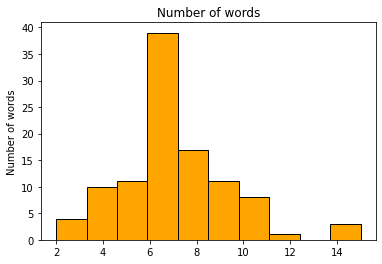

In [34]:
import matplotlib.pyplot as plt

# get number of non-zero entries
num_emb_word_entries = np.count_nonzero(x_test, axis=1)

# plot histogram to get cutoffs
plt.title("Number of words")
plt.hist(num_emb_word_entries, color='orange', edgecolor='black')
plt.ylabel("Number of Sentences with word count")
plt.ylabel("Number of words")

# split based on visual cutoffs
short_max, medium_max = 6, 8
x_short = []
y_short = []
x_medium = []
y_medium = []
x_long = []
y_long = []

for index, num_emb_words in enumerate(num_emb_word_entries):
    current_word = x_test_no_emb[index]
    current_sentiment = y_test[index]
    if num_emb_words <= short_max:
        x_short.append(current_word)
        y_short.append(current_sentiment)
    elif (num_emb_words > short_max) and (num_emb_words < medium_max):
        x_medium.append(current_word)
        y_medium.append(current_sentiment)
    else:
        x_long.append(current_word)
        y_long.append(current_sentiment)
        
print(f"short count = {len(x_short)}")
print(f"medium count = {len(x_medium)}")
print(f"long count = {len(x_long)}")

print(y_long)

# x_short = np.reshape(x_short, (len(x_short), EMBEDDED_VEC_LENGTH, 1)) / len(voc)
# x_medium = np.reshape(x_medium, (len(x_medium), EMBEDDED_VEC_LENGTH, 1)) / len(voc)
# x_long = np.reshape(x_long, (len(x_long), EMBEDDED_VEC_LENGTH, 1)) / len(voc)

# MODEL CREATION - No Embedding
This section outline creating models.

The following are created:

    1. Simple RNN
    2. LSTM
    3. GRU

In [35]:
######
# Simple RNN
######
model_rnn = Sequential()
model_rnn.add(SimpleRNN(20, input_shape=(x_train_no_emb.shape[1], x_train_no_emb.shape[2])))
model_rnn.add(Dropout(0.2))
model_rnn.add(Dense(100))
model_rnn.add(Dense(len(set(train_labels)), activation='softmax'))
model_rnn.summary()

######
# LSTM
######
model_lstm = Sequential()
model_lstm.add(LSTM(20, input_shape=(x_train_no_emb.shape[1], x_train_no_emb.shape[2])))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(100))
model_lstm.add(Dense(len(set(train_labels)), activation='softmax'))
model_lstm.summary()

######
# GRU
######
model_gru = Sequential()
model_gru.add(GRU(20, input_shape=(x_train_no_emb.shape[1], x_train_no_emb.shape[2])))
model_gru.add(Dropout(0.2))
model_gru.add(Dense(100))
model_gru.add(Dense(len(set(train_labels)), activation='softmax'))
model_gru.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 20)                440       
                                                                 
 dropout_3 (Dropout)         (None, 20)                0         
                                                                 
 dense_10 (Dense)            (None, 100)               2100      
                                                                 
 dense_11 (Dense)            (None, 4)                 404       
                                                                 
Total params: 2,944
Trainable params: 2,944
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (

In [36]:
MODELS = {"model_rnn" : model_rnn,
          "model_lstm" : model_lstm,
          "model_gru" : model_gru
         }

for model_name, model in MODELS.items():
    ## Train the model 
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"])
    model.fit(x_train_no_emb, y_train, batch_size=100, epochs=10)

Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 1.3835 - acc: 0.2840
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 1.3575 - acc: 0.3225
Epoch 3/10
5/5 [==============================] - 0s 13ms/step - loss: 1.3144 - acc: 0.3448
Epoch 4/10
5/5 [==============================] - 0s 13ms/step - loss: 1.2932 - acc: 0.3367
Epoch 5/10
5/5 [==============================] - 0s 12ms/step - loss: 1.2781 - acc: 0.3387
Epoch 6/10
5/5 [==============================] - 0s 14ms/step - loss: 1.2813 - acc: 0.3671
Epoch 7/10
5/5 [==============================] - 0s 14ms/step - loss: 1.2815 - acc: 0.3570
Epoch 8/10
5/5 [==============================] - 0s 11ms/step - loss: 1.2831 - acc: 0.3529
Epoch 9/10
5/5 [==============================] - 0s 12ms/step - loss: 1.2933 - acc: 0.3347
Epoch 10/10
5/5 [==============================] - 0s 11ms/step - loss: 1.2909 - acc: 0.3611
Epoch 1/10
5/5 [==============================] - 2s 25ms/step - loss: 1.3809 -

In [37]:
# test the models
for model_name, model in MODELS.items():
    # obtain metrics
    accuracy = model.evaluate(x_test_no_emb, y_test, return_dict=True)['acc']
    predictions = np.argmax(model.predict(x_test_no_emb), axis=1)
    recall = recall_score(predictions, y_test, average='micro')
    precision = precision_score(predictions, y_test, average='micro')
    
    print(f"recall : {recall}; precisicion : {precision}")

4/4 [==============================] - 0s 5ms/step - loss: 1.1513 - acc: 0.5865
recall : 0.5865384615384616; precisicion : 0.5865384615384616
4/4 [==============================] - 0s 5ms/step - loss: 1.1905 - acc: 0.6635
recall : 0.6634615384615384; precisicion : 0.6634615384615384
4/4 [==============================] - 0s 6ms/step - loss: 1.1697 - acc: 0.6635
recall : 0.6634615384615384; precisicion : 0.6634615384615384


In [38]:
# test the models
x_TESTS = [x_short, x_medium, x_long]
y_TESTS = [y_short, y_medium, y_long]

for ind, x_test_divided in enumerate(x_TESTS):
    x_test_divided = np.array(x_test_divided)
    y_test_divided = np.array(y_TESTS[ind])
    for model_name, model in MODELS.items():
        # obtain metrics
        accuracy = model.evaluate(x_test_divided, y_test_divided, return_dict=True)['acc']
        predictions = np.argmax(model.predict(x_test_divided), axis=1)
        recall = recall_score(predictions, y_test_divided, average='micro')
        precision = precision_score(predictions, y_test_divided, average='micro')

        print(f"test index : {ind}")
        print(f"recall : {recall}; precisicion : {precision}")
        print(f"predicted : {predictions}")
        print(f"truth : {y_test_divided}")

2/2 [==============================] - 0s 4ms/step - loss: 1.1970 - acc: 0.6500
test index : 0
recall : 0.65; precisicion : 0.65
predicted : [2 2 2 2 2 2 3 2 2 3 2 2 2 2 2 2 2 2 2 3 2 2 2 1 2 3 2 2 2 2 2 2 2 2 2 2 2
 2 2 1]
truth : [2 2 2 0 0 2 2 2 2 2 0 2 0 2 2 1 2 2 2 2 2 2 0 2 2 0 2 2 2 1 2 2 2 2 0 2 2
 2 2 2]
2/2 [==============================] - 0s 5ms/step - loss: 1.1770 - acc: 0.7750
test index : 0
recall : 0.775; precisicion : 0.775
predicted : [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2]
truth : [2 2 2 0 0 2 2 2 2 2 0 2 0 2 2 1 2 2 2 2 2 2 0 2 2 0 2 2 2 1 2 2 2 2 0 2 2
 2 2 2]
2/2 [==============================] - 0s 6ms/step - loss: 1.1517 - acc: 0.7750
test index : 0
recall : 0.775; precisicion : 0.775
predicted : [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2]
truth : [2 2 2 0 0 2 2 2 2 2 0 2 0 2 2 1 2 2 2 2 2 2 0 2 2 0 2 2 2 1 2 2 2 2 0 2 2
 2 2 2]
1/1 [==============================] - 0s 17ms/step

# EMBEDDINGS
The following section is focused on creating embeddings for the vectors.

In [39]:
# following were used to download the word embeddings for GLOVE 

# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -q glove.6B.zip

In [40]:
## Read the embeddings in the pretrained model (we are using the 100D version of GloVe)
#####
# COPIED FROM LECTURE
####
import os
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [41]:
## Create "embedding_matrix" to index our vocabulary using the GloVe model
#####
# COPIED FROM LECTURE
####
num_tokens = len(voc) 
embedding_dim = 100 ## 100 dimensions
hits = 0 ## number of words that were found in the pretrained model
misses = 0 ## number of words that were missing in the pretrained model

# Prepare embedding matrix for our word list
embedding_matrix_glove = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix_glove[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 1396 words (109 misses)


In [42]:
# open the model
glove_input_file = 'glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.txt.word2vec'
# glove2word2vec(glove_input_file, word2vec_output_file)
embeddings_index = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

In [43]:
## Create "embedding_matrix" to index our vocabulary using the word2vec model
#####
# COPIED FROM LECTURE
####
num_tokens = len(voc) 
embedding_dim = 100 ## 100 dimensions
hits = 0 ## number of words that were found in the pretrained model
misses = 0 ## number of words that were missing in the pretrained model

# Prepare embedding matrix for our word list
embedding_matrix_w2v = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    if word in embeddings_index:
        embedding_vector = embeddings_index[word]
    else:
        embedding_vector = None
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix_w2v[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 1396 words (109 misses)


# MODEL CREATION - with Embeddings
This section outline creating models.

The following models are:

    1. LSTM
    2. Bidirectional LSTM (for FUN!)

With the following embeddings:

    1. GloVe
    2. word2vec

In [44]:
#####
# Glove embedded Layer
#####
glove_embedding_layer = Embedding(num_tokens, embedding_dim,
                                  embeddings_initializer= Constant(embedding_matrix_glove), 
                                  trainable=False)
#####
# word2vec embedded Layer
#####
w2v_embedding_layer = Embedding(num_tokens, embedding_dim,
                                  embeddings_initializer= Constant(embedding_matrix_w2v), 
                                  trainable=False)

In [45]:
######
# Simple LSTM - with GloVe
######
int_sequences_input = Input(shape=(None,), dtype="int64")
embedded_sequences = glove_embedding_layer(int_sequences_input)
x = layers.LSTM(20)(embedded_sequences)
preds = layers.Dense(len(set(train_labels)), activation="softmax")(x)
model_lstm_glove = Model(int_sequences_input, preds)
model_lstm_glove.summary()
######
# Simple LSTM - with word2vec
######
int_sequences_input = Input(shape=(None,), dtype="int64")
embedded_sequences = w2v_embedding_layer(int_sequences_input)
x = layers.LSTM(20)(embedded_sequences)
preds = layers.Dense(len(set(train_labels)), activation="softmax")(x)
model_lstm_w2v = Model(int_sequences_input, preds)
model_lstm_w2v.summary()

######
# Bidirectional LSTM - with GloVe
######
int_sequences_input = Input(shape=(None,), dtype="int64")
embedded_sequences = glove_embedding_layer(int_sequences_input)
x = layers.Bidirectional(layers.LSTM(20, return_sequences=True))(embedded_sequences)
x = layers.Bidirectional(layers.LSTM(20))(x)
preds = layers.Dense(len(set(train_labels)), activation="softmax")(x)
model_lstm_glove = Model(int_sequences_input, preds)
model_lstm_glove.summary()
######
# Bidirectional LSTM - with word2vec
######
int_sequences_input = Input(shape=(None,), dtype="int64")
embedded_sequences = w2v_embedding_layer(int_sequences_input)
x = layers.Bidirectional(layers.LSTM(20, return_sequences=True))(embedded_sequences)
x = layers.Bidirectional(layers.LSTM(20))(x)
preds = layers.Dense(len(set(train_labels)), activation="softmax")(x)
model_lstm_w2v = Model(int_sequences_input, preds)
model_lstm_w2v.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 100)         150500    
                                                                 
 lstm_8 (LSTM)               (None, 20)                9680      
                                                                 
 dense_16 (Dense)            (None, 4)                 84        
                                                                 
Total params: 160,264
Trainable params: 9,764
Non-trainable params: 150,500
_________________________________________________________________
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(N

In [46]:
emb_MODELS = {"LSTM (glove)" : model_lstm_glove,
          "LSTM (word2vec)" : model_lstm_w2v,
          "Bi-LSTM (glove)" : model_lstm_glove,
          "Bi-LSTM (word2vec)" : model_lstm_w2v,
         }
for model_name, model in emb_MODELS.items():
    ## Train the model 
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"])
    model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
4/4 [==============================] - 9s 504ms/step - loss: 1.3779 - acc: 0.3022 - val_loss: 1.2796 - val_acc: 0.5905
Epoch 2/10
4/4 [==============================] - 0s 104ms/step - loss: 1.3352 - acc: 0.3367 - val_loss: 1.2321 - val_acc: 0.5905
Epoch 3/10
4/4 [==============================] - 0s 102ms/step - loss: 1.3131 - acc: 0.3773 - val_loss: 1.1987 - val_acc: 0.5333
Epoch 4/10
4/4 [==============================] - 0s 103ms/step - loss: 1.2986 - acc: 0.4118 - val_loss: 1.1690 - val_acc: 0.5238
Epoch 5/10
4/4 [==============================] - 0s 104ms/step - loss: 1.2846 - acc: 0.4544 - val_loss: 1.1413 - val_acc: 0.6000
Epoch 6/10
4/4 [==============================] - 0s 106ms/step - loss: 1.2725 - acc: 0.4625 - val_loss: 1.1106 - val_acc: 0.6476
Epoch 7/10
4/4 [==============================] - 0s 103ms/step - loss: 1.2561 - acc: 0.5112 - val_loss: 1.1159 - val_acc: 0.6095
Epoch 8/10
4/4 [==============================] - 0s 107ms/step - loss: 1.2347 - acc: 0.55

4/4 [==============================] - 0s 13ms/step - loss: 0.9427 - acc: 0.6154
recall : 0.6153846153846154; precisicion : 0.6153846153846154


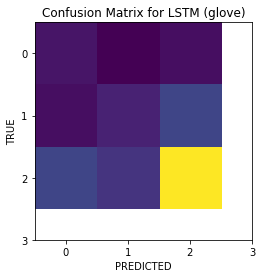

4/4 [==============================] - 0s 12ms/step - loss: 0.9349 - acc: 0.6827
recall : 0.6826923076923077; precisicion : 0.6826923076923077


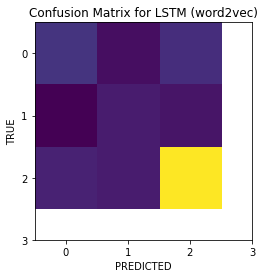

4/4 [==============================] - 0s 11ms/step - loss: 0.9427 - acc: 0.6154
recall : 0.6153846153846154; precisicion : 0.6153846153846154


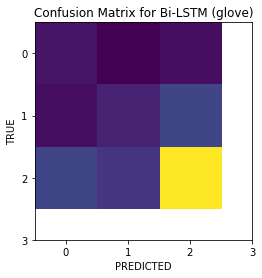

4/4 [==============================] - 0s 10ms/step - loss: 0.9349 - acc: 0.6827
recall : 0.6826923076923077; precisicion : 0.6826923076923077


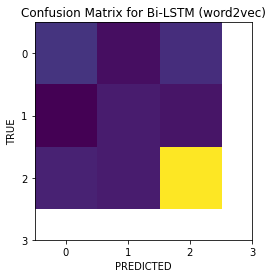

In [47]:
## Train the model 
for model_name, model in emb_MODELS.items():
    # obtain metrics
    accuracy = model.evaluate(x_test, y_test, return_dict=True)['acc']
    predictions = np.argmax(model.predict(x_test), axis=1)
    recall = recall_score(predictions, y_test, average='micro')
    precision = precision_score(predictions, y_test, average='micro')
    conf_matrix = confusion_matrix(predictions, y_test)
    print(f"recall : {recall}; precisicion : {precision}")
    plt.imshow(conf_matrix)
    labels = index2meaning.keys()
    plt.title(f"Confusion Matrix for {model_name}")
    plt.yticks(range(len(labels)), labels)
    plt.xticks(range(len(labels)), labels)
    plt.ylabel("TRUE")
    plt.xlabel("PREDICTED")
    plt.show()